Load Data

In [1]:
# install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# download spark2.4.5
!wget -q https://archive.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
# unzip it
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
# install findspark
!pip install -q findspark
# Google Colab has Java 11 available, test it using below command -
!ls /usr/lib/jvm
#install pyarrow
!pip install -U pyarrow

default-java		   java-11-openjdk-amd64     java-8-openjdk-amd64
java-1.11.0-openjdk-amd64  java-1.8.0-openjdk-amd64
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()
spark_params = {
"spark.executor.memory" : "4g",
"spark.driver.memory": "4g",
"spark.memory.fraction": "0.9"}
for param, value in spark_params.items():
  spark.conf.set(param, value)

!wget "https://datasets.imdbws.com/name.basics.tsv.gz"
!wget "https://datasets.imdbws.com/title.akas.tsv.gz"
!wget "https://datasets.imdbws.com/title.basics.tsv.gz"
!wget "https://datasets.imdbws.com/title.crew.tsv.gz"
!wget "https://datasets.imdbws.com/title.episode.tsv.gz"
!wget "https://datasets.imdbws.com/title.principals.tsv.gz"
!wget "https://datasets.imdbws.com/title.ratings.tsv.gz"

title_ratings = spark.read.csv("title.ratings.tsv.gz", sep='\t', header=True)
title_basics = spark.read.csv("title.basics.tsv.gz", sep='\t', header=True)

--2022-11-07 17:35:23--  https://datasets.imdbws.com/name.basics.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 13.224.167.31, 13.224.167.100, 13.224.167.126, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|13.224.167.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 236081246 (225M) [binary/octet-stream]
Saving to: ‘name.basics.tsv.gz.1’

name.basics.tsv.gz. 100%[===================>] 225.14M  18.0MB/s    in 13s     

2022-11-07 17:35:37 (16.9 MB/s) - ‘name.basics.tsv.gz.1’ saved [236081246/236081246]

--2022-11-07 17:35:37--  https://datasets.imdbws.com/title.akas.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 13.224.167.31, 13.224.167.100, 13.224.167.126, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|13.224.167.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 286770276 (273M) [binary/octet-stream]
Saving to: ‘title.akas.tsv.gz.1’

title.akas.tsv.gz.1 100%[==================

In [3]:
print(title_basics.show(5))
print(title_ratings.show(5))

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             4|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            12|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|     1893|     \N|             1|        Comedy

Normality Tests

In [4]:
import pandas as pd
from scipy import stats
from statistics import mean, stdev

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import t

Get necessery values

In [5]:
runtime = title_basics.select('runtimeMinutes').filter(
    ~title_basics.runtimeMinutes.isin(['\\N', 'Reality-TV', 
                                       'Talk-Show', 'Documentary', 
                                       'Animation,Comedy,Family', 'Game-Show', 
                                       'Game-Show,Reality-TV']))
runtime = list(runtime.toPandas()['runtimeMinutes'])
runtime = [float(x) for x in runtime]

ratings = list(title_ratings.select('averageRating').toPandas()['averageRating'])
ratings = [float(x) for x in ratings]

votes = list(title_ratings.select('numVotes').toPandas()['numVotes'])
votes = [float(x) for x in votes]

In [6]:
def compare_with_normal_dist(sample):
  # Create a gaussian distribution
  m = mean(sample)
  sd = stdev(sample)
  x = np.random.normal(loc = m, scale = sd, size = len(sample))

  # Binning
  n_x, bins_x = np.histogram(x, bins = int(np.ceil(np.sqrt(x.size))))
  n_y, bins_y = np.histogram(sample, bins = int(np.ceil(np.sqrt(len(sample)))))

  # Normalizings
  n_x = n_x / len(x) / len(bins_y)
  n_y = n_y / len(sample) / len(bins_x)

  # Plotting
  plt.plot(bins_x[:-1], n_x)
  plt.plot(bins_y[:-1], n_y)
  plt.show()  
  

Ratings distribution

KstestResult(statistic=0.07666292631247779, pvalue=0.0)
mean: 6.949523867635122, standard deviation: 1.3906164850084959


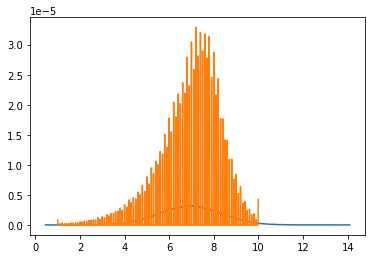

In [7]:
m = mean(ratings)
sd = stdev(ratings)

print(stats.kstest([(x - m) / sd for x in ratings], "norm"))
print(f"mean: {m}, standard deviation: {sd}")

compare_with_normal_dist(ratings)

Number of votes distribution

KstestResult(statistic=0.47606909600802344, pvalue=0.0)
mean: 1042.048970862032, standard deviation: 17277.84294273762


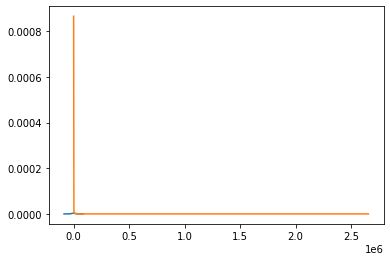

In [8]:
m = mean(votes)
sd = stdev(votes)

print(stats.kstest([(x - m) / sd for x in votes], "norm"))
print(f"mean: {m}, standard deviation: {sd}")

compare_with_normal_dist(votes)

Run time distribution

KstestResult(statistic=0.2728775588112143, pvalue=0.0)
mean: 43.92507391062506, standard deviation: 71.05358486665897


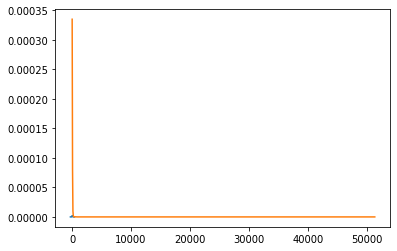

In [9]:
m = mean(runtime)
sd = stdev(runtime)

print(stats.kstest([(x - m) / sd for x in runtime], "norm"))
print(f"mean: {m}, standard deviation: {sd}")

compare_with_normal_dist(runtime)